In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy

In [2]:
plt.rc("figure, dpi=100")

batch_size=100

In [3]:
# transform images into normalized tensors

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)),
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [4]:
def init_weights(shape):
  # kaiming He Initialization
  std=np.sqrt(2. / shape[0])
  w = torch.randn(size=shape) * std
  w.requires_grad=True
  return w

def rectify(x):
  # Rectified Linear Unit (ReLU)
  return torch.max(torch.zeros_like(x), x)

In [5]:
class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])


# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

### Dropout function for Task 2

<div style="color: green; font-weight: bold">Essentially the same as sample solution.</div>

In [10]:
# def dropout(X, p_drop=0.5):
#     if 0 < p_drop < 1:
#         mask = np.random.binomial(1, p=p_drop, size=X.shape)  # Generate a binary mask
#         dropped_X = np.where(mask == 1, 0, X / (1 - p_drop))   # Apply dropout mask and scale non-dropped elements
#         return dropped_X
#     else:
#         return X

def dropout(X, p_drop=0.5):
    if 0 < p_drop < 1:
        mask = torch.bernoulli(torch.ones_like(X) * (1 - p_drop))  # Generate a binary mask
        dropped_X = torch.where(mask == 1, torch.zeros_like(X), X / (1 - p_drop))   # Apply dropout mask and scale non-dropped elements
        return dropped_X
    else:
        return X

<div style="color: green; font-weight: bold">

Execution of Task 1 in section of task 2 --> confusing. 

</div>

In [7]:
# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")


Epoch: 0
Mean Train Loss: 3.97e-01
Mean Test Loss:  1.68e-01
Epoch: 10
Mean Train Loss: 1.47e-01
Mean Test Loss:  2.62e-01
Epoch: 20
Mean Train Loss: 8.95e-02
Mean Test Loss:  5.02e-01
Epoch: 30
Mean Train Loss: 6.69e-02
Mean Test Loss:  6.55e-01
Epoch: 40
Mean Train Loss: 5.25e-02
Mean Test Loss:  6.99e-01
Epoch: 50
Mean Train Loss: 3.54e-02
Mean Test Loss:  9.90e-01
Epoch: 60
Mean Train Loss: 2.45e-02
Mean Test Loss:  7.82e-01
Epoch: 70
Mean Train Loss: 2.33e-02
Mean Test Loss:  7.72e-01
Epoch: 80
Mean Train Loss: 2.00e-02
Mean Test Loss:  8.03e-01
Epoch: 90
Mean Train Loss: 1.89e-02
Mean Test Loss:  9.18e-01
Epoch: 100
Mean Train Loss: 1.18e-02
Mean Test Loss:  8.72e-01


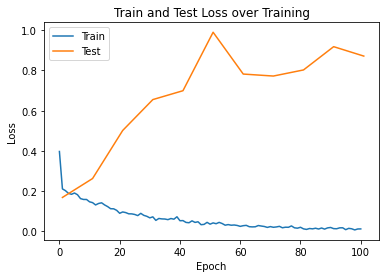

In [8]:
plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

<div style="color: green; font-weight: bold">

Dropout applied during training not in the model calculation function. However, correct solution and plot.

</div>

In [11]:
# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        
        #-----------------------------
        # apply dropout
        dropped_X = dropout(x, p_drop=0.5)
        #-------------------------------
        
        # feed input through model
        noise_py_x = model(dropped_X, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")


Epoch: 0
Mean Train Loss: 6.20e-01
Mean Test Loss:  2.38e-01
Epoch: 10
Mean Train Loss: 3.12e-01
Mean Test Loss:  1.50e-01
Epoch: 20
Mean Train Loss: 2.88e-01
Mean Test Loss:  1.44e-01
Epoch: 30
Mean Train Loss: 2.75e-01
Mean Test Loss:  1.32e-01
Epoch: 40
Mean Train Loss: 2.37e-01
Mean Test Loss:  1.27e-01
Epoch: 50
Mean Train Loss: 2.40e-01
Mean Test Loss:  1.66e-01
Epoch: 60
Mean Train Loss: 2.26e-01
Mean Test Loss:  1.15e-01
Epoch: 70
Mean Train Loss: 2.31e-01
Mean Test Loss:  1.68e-01
Epoch: 80
Mean Train Loss: 2.05e-01
Mean Test Loss:  1.35e-01
Epoch: 90
Mean Train Loss: 2.24e-01
Mean Test Loss:  1.20e-01
Epoch: 100
Mean Train Loss: 2.33e-01
Mean Test Loss:  1.51e-01


<div style="color: green; font-weight: bold">

Performance is better than sample solution.

</div>

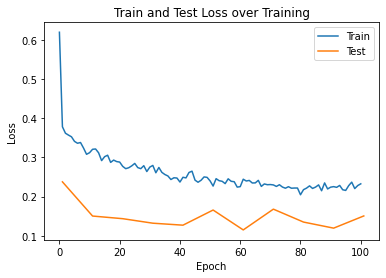

In [ ]:
# plotting after drop
plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

<div style="color: green; font-weight: bold">

Includes sample solution and gives even more information.

</div>

The dropout function is a regularization technique commonly used in neural networks to reduce overfitting. It randomly sets a fraction of the input elements to zero during training.
Explaination of how the dropout function works and reduces overfitting:

1. Dropout during Training:
- During training, for each element in the input tensor X, the function generates a binary mask using a random process. The mask has the same shape as X and contains values of either 1 or 0.
- The probability of setting an element to 1 in the mask is determined by the dropout probability p_drop. For example, if p_drop = 0.5, there is a 50% chance of an element being set to 1.
- The binary mask is element-wise multiplied with X. If an element in the mask is 1, the corresponding element in X is set to zero; otherwise, it remains unchanged.
- By randomly zeroing out elements in X during each training step, the dropout function creates different "thinned" versions of the network. This helps prevent the network from relying too much on specific input features and encourages it to learn more robust and general representations.

2. Scaling during Testing:
- During testing or inference, when the model is making predictions, dropout is not applied. Instead, the original input tensor X is returned without any modifications.
- However, to ensure that the expected value of the output remains the same during testing as during training, the non-dropped elements in X are scaled by a factor of (1 - p_drop). This scaling compensates for the fact that some elements were randomly set to zero during training.
- Scaling during testing helps ensure that the model's predictions are consistent and not affected by dropout, allowing the model to generalize well to unseen data.


How the function reduces overfitting:
- Dropout acts as a form of regularization by reducing the model's reliance on individual neurons or specific combinations of features during training. This, in turn, helps prevent overfitting.
- By randomly dropping out neurons during each training step, dropout creates an ensemble of thinned networks that work in parallel. Each thinned network only has access to a fraction of the neurons, forcing them to learn more robust representations.
- Dropout essentially forces the network to learn redundant representations and encourages the sharing of information among neurons. This helps prevent complex co-adaptations between neurons and encourages the network to generalize better to unseen data.
- Dropout can be seen as a way to introduce noise or perturbations into the training process, making the network more robust to noise in the input data.
- Dropout can also be viewed as a way to prevent overfitting by approximating model averaging. During training, each thinned network is trained independently, and during testing, the outputs of all thinned networks are averaged to get the final prediction. This approximation of model averaging helps reduce the variance of the model's predictions.

### Dropout Model

<div style="color: green; font-weight: bold">Essentially the same as sample solution.</div>

In [17]:
def dropout_model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    # Dropout at the input layer
    X_dropped = dropout(X, p_drop_input)

    # Hidden layer 1
    h = rectify(X_dropped @ w_h)
    h_dropped = dropout(h, p_drop_hidden)

    # Hidden layer 2
    h2 = rectify(h_dropped @ w_h2)
    h2_dropped = dropout(h2, p_drop_hidden)

    # Output layer
    pre_softmax = torch.matmul(h2_dropped, w_o)
    return pre_softmax

<div style="color: green; font-weight: bold">Essentially the same as sample solution.</div>

In [19]:
# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        
        # feed input through model
        noise_py_x = dropout_model(x, w_h, w_h2, w_o, 0.5, 0.2)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")


Epoch: 0
Mean Train Loss: 1.29e+00
Mean Test Loss:  3.08e+00
Epoch: 10
Mean Train Loss: 7.75e-01
Mean Test Loss:  2.79e+00
Epoch: 20
Mean Train Loss: 8.18e-01
Mean Test Loss:  3.27e+00
Epoch: 30
Mean Train Loss: 8.20e-01
Mean Test Loss:  3.50e+00
Epoch: 40
Mean Train Loss: 8.68e-01
Mean Test Loss:  3.62e+00
Epoch: 50
Mean Train Loss: 8.93e-01
Mean Test Loss:  3.72e+00
Epoch: 60
Mean Train Loss: 9.00e-01
Mean Test Loss:  3.99e+00
Epoch: 70
Mean Train Loss: 9.42e-01
Mean Test Loss:  3.94e+00
Epoch: 80
Mean Train Loss: 9.65e-01
Mean Test Loss:  4.27e+00
Epoch: 90
Mean Train Loss: 9.83e-01
Mean Test Loss:  4.21e+00
Epoch: 100
Mean Train Loss: 1.00e+00
Mean Test Loss:  4.29e+00


<div style="color: green; font-weight: bold">Essentially the same as sample solution.</div>

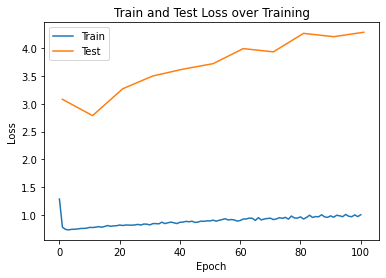

In [20]:
# plotting after drop
plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

<div style="color: green; font-weight: bold">

Task 3 is missing.

</div>

### Question 4

In [21]:
#Creating CNN 


import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 2 * 2, 625)  # Adjust the input size based on the number of output pixels of the CNN
        self.fc2 = nn.Linear(625, 10)  # Pre-softmax output layer with 10 outputs

        # Initialize the weights
        self.init_weights()

    def init_weights(self):
        # Initialize the weights for convolutional layers
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.xavier_uniform_(self.conv3.weight)

        # Initialize the weights for fully connected layers
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(self.conv3(x))

        x = x.view(-1, 128 * 2 * 2)  # Flatten the input
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the network
net = Net()

# Print the network architecture
print(net)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=625, bias=True)
  (fc2): Linear(in_features=625, out_features=10, bias=True)
)


<div style="color: green; font-weight: bold">

Generation of the correct filters. 

</div>

100.0%


Extracting path_to_test_set\MNIST\raw\train-images-idx3-ubyte.gz to path_to_test_set\MNIST\raw


100.0%


Extracting path_to_test_set\MNIST\raw\train-labels-idx1-ubyte.gz to path_to_test_set\MNIST\raw




100.0%
100.0%


Extracting path_to_test_set\MNIST\raw\t10k-images-idx3-ubyte.gz to path_to_test_set\MNIST\raw

Extracting path_to_test_set\MNIST\raw\t10k-labels-idx1-ubyte.gz to path_to_test_set\MNIST\raw



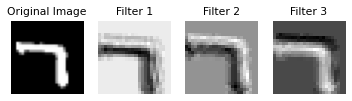

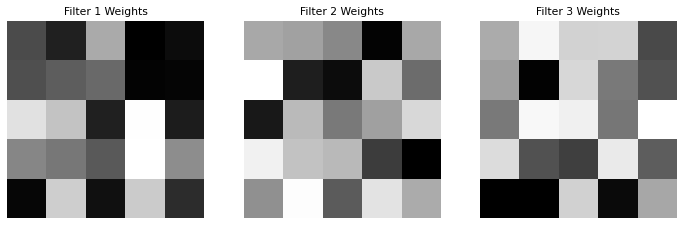

In [22]:

# #Train the model. Then, plot:
#  one image from the test set
#  its convolution with 3 filters of the first convolutional layer
#  the corresponding filter weights (these should be 5 by 5 images).


from matplotlib.text import FontProperties
import torch
import torchvision
import matplotlib.pyplot as plt

# Load the pre-trained model

net.eval()

# Load the test set
test_dataset = torchvision.datasets.MNIST(root="path_to_test_set", train=False, download=True, transform=torchvision.transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

# Get one image from the test set
image, _ = next(iter(test_loader))
plt.rc('font', size=9)
# Plot the original image
plt.subplot(141)
plt.title("Original Image")
plt.rc('font', size=9)
plt.imshow(image.squeeze(), cmap="gray")
plt.axis("off")

# Get the activations from the first convolutional layer
activations = net.conv1(image)
activations = activations.squeeze().detach()

# Plot the convolutions with three filters from the first convolutional layer
plt.subplot(142)

plt.title("Filter 1")


plt.imshow(activations[0], cmap="gray")
plt.axis("off")

plt.subplot(143)
plt.title("Filter 2")
plt.imshow(activations[1], cmap="gray")
plt.axis("off")

plt.subplot(144)
plt.title("Filter 3")
plt.imshow(activations[2], cmap="gray")
plt.axis("off")

plt.show()

# Plot the corresponding filter weights
filter_weights = net.conv1.weight.squeeze().detach()

plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"Filter {i + 1} Weights")
    plt.imshow(filter_weights[i], cmap="gray")
    plt.axis("off")

plt.show()


In [23]:
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=625, bias=True)
  (fc2): Linear(in_features=625, out_features=10, bias=True)
)


In [24]:
# Add one convolutional layer (you may adjust the number of filters)



import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=2)  # New convolutional layer

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 2 * 2, 625)  # Adjust the input size based on the number of output pixels of the CNN
        self.fc2 = nn.Linear(625, 10)  # Pre-softmax output layer with 10 outputs

        # Initialize the weights
        self.init_weights()

    def init_weights(self):
        # Initialize the weights for convolutional layers
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.xavier_uniform_(self.conv3.weight)
        nn.init.xavier_uniform_(self.conv4.weight)  # Initialize weights for the new convolutional layer

        # Initialize the weights for fully connected layers
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))  # Add the new convolutional layer

        x = x.view(-1, 256 * 2 * 2)  # Flatten the input
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



net=Net()


<div style="color: green; font-weight: bold">

Train and Test loss plots are missing 

</div>

In [27]:
# Computing Test Errror


import torch
import torchvision
import torch.nn as nn


net.eval()

# Load the test set
test_dataset = torchvision.datasets.MNIST(root="path_to_test_set", train=False, download=True, transform=torchvision.transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# Evaluate the model on the test set
total_samples = len(test_dataset)
correct_predictions = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()

test_error = 1 - (correct_predictions / total_samples)
print(f"Test Error: {test_error:.4f}")


Test Error: 0.9059
